In [9]:
import seaborn as sns
import pandas as pd
import numpy as np
import mysql.connector
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'

In [2]:
#connecting to and querying the MySQL database hosted in Google Cloud
#database is publicly available with the following credentials until 8 November 2023 (under free trial):
db_connection = mysql.connector.connect(
  host="",
  user="",
  passwd="",
  database="mps_data"
)
cursor = db_connection.cursor()

#extract and assign to a dataframe the data from the view 
#created previously in MySQL for inference purposes
query = '''
SELECT * FROM rq2_test_predictions;
'''
test_predictions = pd.read_sql_query(query, db_connection)

/var/folders/vs/q72gbwjx6nz56xv99w7qbf0c0000gn/T/ipykernel_7991/570893996.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test_predictions = pd.read_sql_query(query, db_connection)


In [3]:
test_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31383 entries, 0 to 31382
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          31383 non-null  int64  
 1   true_label  31383 non-null  int64  
 2   nn_0        31383 non-null  float64
 3   nn_1        31383 non-null  float64
 4   nn_2        31383 non-null  float64
 5   xgb_0       31383 non-null  float64
 6   xgb_1       31383 non-null  float64
 7   xgb_2       31383 non-null  float64
 8   logreg_0    31383 non-null  float64
 9   logreg_1    31383 non-null  float64
 10  logreg_2    31383 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 2.6 MB


In [4]:
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

#extracting true labels
y_true = test_predictions['true_label'].values
n_classes = 3

# Lists to store results
models = ['nn', 'xgb', 'logreg']
log_losses = []
accuracies = []

# Lists to store results per class
precisions = [[] for _ in range(n_classes)]
recalls = [[] for _ in range(n_classes)]
f1_scores = [[] for _ in range(n_classes)]
aucs = [[] for _ in range(n_classes)]

for model in models:
    # Extracting predicted probabilities for the current model
    y_pred = test_predictions[[f"{model}_0", f"{model}_1", f"{model}_2"]].values
    
    # Calculating log loss and accuracy
    ll = log_loss(y_true, y_pred)
    log_losses.append(ll)
    
    # Converting probabilities to class labels and computing accuracy
    y_pred_class = y_pred.argmax(axis=1)
    acc = accuracy_score(y_true, y_pred_class)
    accuracies.append(acc)

    # Computing other metrics per class
    for i in range(n_classes):
        y_true_i = (y_true == i).astype(int)
        y_pred_i = y_pred[:, i]
        y_pred_class_i = (y_pred_class == i).astype(int)
        
        precisions[i].append(precision_score(y_true_i, y_pred_class_i))
        recalls[i].append(recall_score(y_true_i, y_pred_class_i))
        f1_scores[i].append(f1_score(y_true_i, y_pred_class_i))
        aucs[i].append(roc_auc_score(y_true_i, y_pred_i))

# Constructing results DataFrame
data = {
    'Model': models,
    'Log Loss': log_losses,
    'Accuracy': accuracies
}
for i in range(n_classes):
    data[f'AUC ({i})'] = aucs[i]
for i in range(n_classes):
    data[f'Precision ({i})'] = precisions[i]
for i in range(n_classes):
    data[f'Recall ({i})'] = recalls[i]
for i in range(n_classes):
    data[f'F1 Score ({i})'] = f1_scores[i]

results = pd.DataFrame(data)

results

,Model,Log Loss,Accuracy,AUC (0),AUC (1),AUC (2),Precision (0),Precision (1),Precision (2),Recall (0),Recall (1),Recall (2),F1 Score (0),F1 Score (1),F1 Score (2)
0,nn,1.012234,0.502310,0.719085,0.549133,0.715751,0.605185,0.259827,0.518483,0.605410,0.221212,0.574610,0.605297,0.238970,0.545105
1,xgb,1.022574,0.492400,0.711530,0.548219,0.702158,0.588839,0.279332,0.514809,0.610999,0.271014,0.500964,0.599715,0.275110,0.507792
2,logreg,1.014272,0.512985,0.709747,0.567016,0.703141,0.582645,0.312832,0.487177,0.651986,0.147431,0.600636,0.615368,0.200412,0.537990


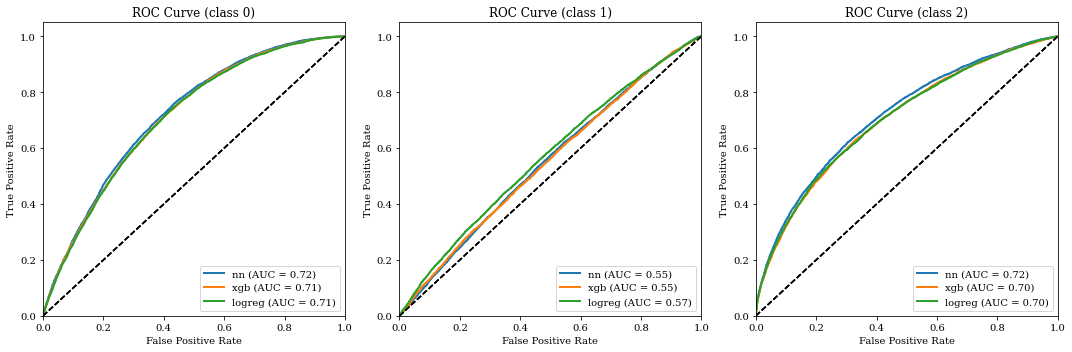

In [5]:
n_classes = 3

y_true_bin = np.zeros((y_true.size, y_true.max()+1))
y_true_bin[np.arange(y_true.size), y_true] = 1

fig, axes = plt.subplots(nrows=1, ncols=n_classes, figsize=(15, 5))

for class_idx in range(n_classes):
    ax = axes[class_idx]
    
    for model in ['nn', 'xgb', 'logreg']:
        y_pred = test_predictions[[f"{model}_0", f"{model}_1", f"{model}_2"]].values
        
        fpr, tpr, _ = roc_curve(y_true_bin[:, class_idx], y_pred[:, class_idx])
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {roc_auc:.2f})')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve (class {class_idx})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.legend(loc="lower right")
    
plt.tight_layout()
plt.savefig('plots/rq2_roc_curves.png', dpi=200, bbox_inches='tight')
plt.show()

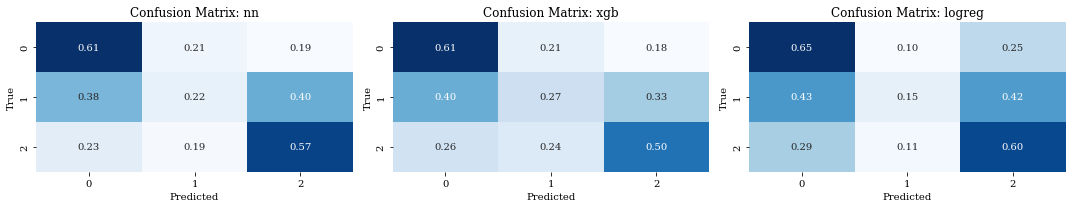

In [6]:

fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(15, 3))

for idx, model in enumerate(models):
    # Extracting predicted probabilities for the current model
    y_pred_probs = test_predictions[[f"{model}_0", f"{model}_1", f"{model}_2"]].values
    
    # Converting probabilities to class labels
    y_pred_class = y_pred_probs.argmax(axis=1)
    
    # Creating confusion matrix
    cm = confusion_matrix(y_true, y_pred_class)
    
    # Normalizing confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting confusion matrix using a heatmap
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'Confusion Matrix: {model}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
    
# Adjusting layout
plt.tight_layout()
plt.savefig('plots/rq2_confusion_matrix.png', dpi=200)
plt.show()

In [12]:
# Convert probabilities to class predictions
test_predictions['nn_pred'] = test_predictions[['nn_0', 'nn_1', 'nn_2']].idxmax(axis=1).str[-1].astype(int)
test_predictions['xgb_pred'] = test_predictions[['xgb_0', 'xgb_1', 'xgb_2']].idxmax(axis=1).str[-1].astype(int)
test_predictions['logreg_pred'] = test_predictions[['logreg_0', 'logreg_1', 'logreg_2']].idxmax(axis=1).str[-1].astype(int)

# Generate classification reports
nn_report = classification_report(test_predictions['true_label'], test_predictions['nn_pred'], target_names=["Class 0", "Class 1", "Class 2"])
xgb_report = classification_report(test_predictions['true_label'], test_predictions['xgb_pred'], target_names=["Class 0", "Class 1", "Class 2"])
logreg_report = classification_report(test_predictions['true_label'], test_predictions['logreg_pred'], target_names=["Class 0", "Class 1", "Class 2"])

# Print classification reports
print("Neural Network Classification Report:")
print(nn_report)

print("\nXGBoost Classification Report:")
print(xgb_report)

print("\nLogistic Regression Classification Report:")
print(logreg_report)

Neural Network Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.61      0.61     13419
     Class 1       0.26      0.22      0.24      7590
     Class 2       0.52      0.57      0.55     10374

    accuracy                           0.50     31383
   macro avg       0.46      0.47      0.46     31383
weighted avg       0.49      0.50      0.50     31383


XGBoost Classification Report:
              precision    recall  f1-score   support

     Class 0       0.59      0.61      0.60     13419
     Class 1       0.28      0.27      0.28      7590
     Class 2       0.51      0.50      0.51     10374

    accuracy                           0.49     31383
   macro avg       0.46      0.46      0.46     31383
weighted avg       0.49      0.49      0.49     31383


Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Class 0       0.58      0.65      0.62     13419
     Class 1   